$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

# The General Linear Model for one voxel

Here we get the convolved regressor and voxel time-courses from the
[convolution](convolution) notebook, and run the general linear model.

Start with our usual imports:

In [1]:
import numpy as np
# Only show 6 decimals when printing
np.set_printoptions(precision=6)

import matplotlib.pyplot as plt
%matplotlib inline

import nibabel as nib

from scipy.stats import gamma

Load the 4D image ready for analysis:

In [2]:
img = nib.load('ds114_sub009_t2r1.nii')
data = img.get_fdata()
data.shape

(64, 64, 30, 173)

In [3]:
# The Time to Repeat (time between start of one scan and the next).
TR = 2.5

## The haemodynamic response function

You saw this in [convolution](convolution):

In [4]:
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

The HRF sampled every `TR` seconds.

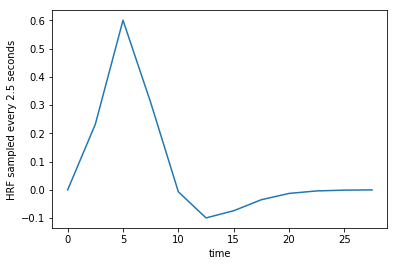

In [5]:
tr_times = np.arange(0, 30, TR)
hrf_at_trs = hrf(tr_times)
len(hrf_at_trs)
plt.plot(tr_times, hrf_at_trs)
plt.xlabel('time')
plt.ylabel('HRF sampled every 2.5 seconds');

## The neural predictor

From [convolution](convolution):

In [6]:
#- Make new zero vector for neural prediction
neural_prediction = np.zeros(img.shape[-1])
#- Read the file into an array called "task".
#- "task" should have 3 columns (onset, duration, amplitude)
task = np.loadtxt('ds114_sub009_t2r1_cond.txt')
#- Select first two columns and divide by TR
ons_durs = task[:, :2] / TR
#- Fill in values of 1 for positions of on blocks in time course
# Convert onsets, durations to integers first
ons_durs = np.round(ons_durs).astype(int)
for onset, duration in ons_durs:
    neural_prediction[onset:onset + duration] = 1

Plot the on-off neural predictor:

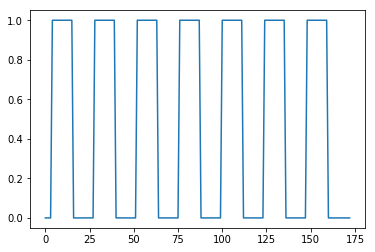

In [7]:
all_tr_times = np.arange(173)
plt.plot(all_tr_times, neural_prediction);

## Haemodyamic predictor


In [8]:
convolved = np.convolve(neural_prediction, hrf_at_trs)
N = len(neural_prediction)  # M == n_vols == 173
M = len(hrf_at_trs)  # M == 12
convolved = convolved[:N]

Plot the neural and haemodyanmic prediction:

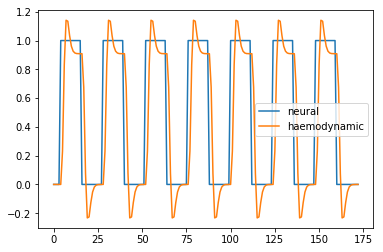

In [9]:
plt.plot(all_tr_times, neural_prediction, label='neural')
plt.plot(all_tr_times, convolved, label='haemodynamic')
plt.legend();

## Voxel time course

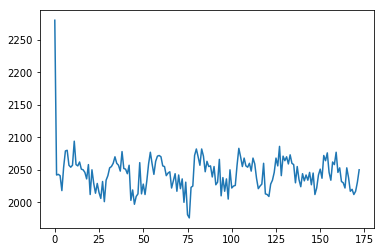

In [10]:
# This is slicing over all three of the space axes
voxel_time_course = data[42, 32, 19, :]
plt.plot(voxel_time_course);

# Using the convolved regressor in the linear model

Now we are going to use the convolved regressor we just made to do a simple
regression on this voxel time course.

First drop the first element of both regressors, to remove the T1 artifact:

In [11]:
# Drop the first volumes-worth from the regressor
convolved = convolved[1:]
voxel_time_course = voxel_time_course[1:]

Next we make our *design matrix*.  It has a column for the convolved
regressor, and a column of ones:

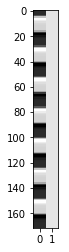

In [12]:
N = len(convolved)
X = np.ones((N, 2))
X[:, 0] = convolved
plt.imshow(X, cmap='gray', aspect=0.1);

$\newcommand{\yvec}{\vec{y}}$
$\newcommand{\xvec}{\vec{x}}$
$\newcommand{\evec}{\vec{\varepsilon}}$
$\newcommand{Xmat}{\boldsymbol X} \newcommand{\bvec}{\vec{\beta}}$
$\newcommand{\bhat}{\hat{\bvec}} \newcommand{\yhat}{\hat{\yvec}}$

As you will remember from the [General Linear Model](glm_intro), the model is:

$$
\yvec = \Xmat \bvec + \evec
$$

We can get our least squares parameter *estimates* for $\bvec$ with:

$$
\bhat = \Xmat^+y
$$

where $\Xmat^+$ is the *pseudoinverse* of $\Xmat$.  When $\Xmat$ is
invertible, the pseudoinverse is given by:

$$
\Xmat^+ = (\Xmat^T \Xmat)^{-1} \Xmat^T
$$

Let’s calculate the pseudoinverse for our design:

In [13]:
import numpy.linalg as npl
Xp = npl.pinv(X)
Xp.shape

(2, 172)

We calculate $\bhat$:

In [14]:
beta_hat = Xp.dot(voxel_time_course)
beta_hat

array([  30.790308, 2029.763361])

We can then calculate $\yhat$ (also called the *fitted data*):

41871.30398468149


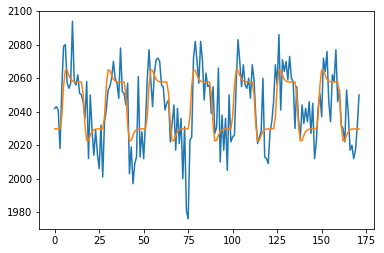

In [15]:
y_hat = X.dot(beta_hat)
e_vec = voxel_time_course - y_hat
print(np.sum(e_vec ** 2))
plt.plot(voxel_time_course)
plt.plot(y_hat)

# Doing a t-test on the linear model fit

Our plan now is to do an hypothesis test on our $\bhat$ values.

The $\bhat$ values are sample estimates of the unobservable true $\bvec$
parameters.

Because the $\bhat$ values are sample estimates, the values we have depend on
the particular sample we have, and the particular instantiation of the random
noise (residuals).   If we were to take another set of data from the same
voxel during the same task, we would get another estimate, because there would
be different instantiation of the random noise.  It’s possible to show that
the variance / covariance of the $\hat\beta$ estimates is:

$$
\text{Cov}(\hat\beta) = \sigma^2 \left(X^T X\right)^{-1}.
$$

where $\sigma^2$ is the true unknown variance of the errors. See [wikipedia
proof](https://en.wikipedia.org/wiki/Proofs_involving_ordinary_least_squares#Unbiasedness_of_.CE.B2.CC.82),
and [stackoverflow proof](http://stats.stackexchange.com/questions/72940/covariance-matrix-of-least-squares-estimator-hat-beta).

We can use an estimate $\hat\sigma^2$ of $\sigma^2$ to give us estimated
standard errors of the variance covariance (see: Unbiased estimate of population variance):

In [16]:
y = voxel_time_course
y_hat = X.dot(beta_hat)
residuals = y - y_hat
# Residual sum of squares
RSS = np.sum(residuals ** 2)
# Degrees of freedom: n - no independent columns in X
df = X.shape[0] - npl.matrix_rank(X)
# Mean residual sum of squares
MRSS = RSS / df
# This is our s^2
s2_hat = MRSS
print(s2_hat)
print(np.sqrt(s2_hat))

246.30178814518527
15.694004847239766


We now have an standard estimate of the variance / covariance of the $\bhat$:

In [17]:
v_cov = s2_hat * npl.inv(X.T.dot(X))

In particular, I can now divide my estimate for the first parameter, by the
standard error of that estimate:

In [18]:
numerator = beta_hat[0]
denominator = np.sqrt(v_cov[0, 0])
t_stat = numerator / denominator
print(t_stat)

12.796927385112065


I can look up the probability of this t statistic using `scipy.stats`:

In [19]:
from scipy.stats import t as t_dist
# Get p value for t value using cumulative density dunction
# (CDF) of t distribution
ltp = t_dist.cdf(t_stat, df) # lower tail p
p = 1 - ltp # upper tail p
p

0.0

## Compare our manual estimation to R

Finally let’s save the regressor and the voxel time course for us to compare this analysis to the `lm` estimation in R:

In [20]:
np.savetxt('ds114_sub009_t2r1_conv.txt', convolved)
np.savetxt('voxel_time_course.txt', voxel_time_course)

Here are the commands to run the same analysis in R:

```
# Simple regression model in R
# Load the voxel time course
voxels = read.table('voxel_time_course.txt')$V1
# Load the convolved regressor
convolved = read.table('ds114_sub009_t2r1_conv.txt')$V1
# Fit linear model
res = lm(voxels ~ convolved)
print(summary(res))
```